In [ ]:
# Install required packages
!pip install -q transformers datasets sentencepiece
!pip install -q pytorch-lightning wandb
!pip install -q donut-python

# !huggingface-cli login this shouldh be done from the terminal

In [1]:
from transformers import DonutProcessor, VisionEncoderDecoderModel

processor = DonutProcessor.from_pretrained("Jac-Zac/thesis_test_donut")
model = VisionEncoderDecoderModel.from_pretrained("Jac-Zac/thesis_test_donut")

In [6]:
import re
import json
import torch
from tqdm.auto import tqdm
import numpy as np
import random
from PIL import Image

from donut import JSONParseEvaluator
from datasets import load_dataset

device = "cuda" if torch.cuda.is_available() else "cpu"

model.eval()
model.to(device)

output_list = []
accs = []

image_path = "/Users/jaczac/Github/Thesis/donut_example/copy/img_resized"

dataset = load_dataset(image_path, split="validation")


for idx, sample in tqdm(enumerate(dataset), total=len(dataset)):
    # prepare encoder inputs
    pixel_values = processor(sample["image"].convert("RGB"), return_tensors="pt").pixel_values
    pixel_values = pixel_values.to(device)
    # prepare decoder inputs
    task_prompt = "<s_herbarium>"
    decoder_input_ids = processor.tokenizer(task_prompt, add_special_tokens=False, return_tensors="pt").input_ids
    decoder_input_ids = decoder_input_ids.to(device)
    
    # autoregressively generate sequence
    outputs = model.generate(
            pixel_values,
            decoder_input_ids=decoder_input_ids,
            max_length=model.decoder.config.max_position_embeddings,
            early_stopping=True,
            pad_token_id=processor.tokenizer.pad_token_id,
            eos_token_id=processor.tokenizer.eos_token_id,
            use_cache=True,
            num_beams=1,
            bad_words_ids=[[processor.tokenizer.unk_token_id]],
            return_dict_in_generate=True,
        )

    # turn into JSON
    seq = processor.batch_decode(outputs.sequences)[0]
    seq = seq.replace(processor.tokenizer.eos_token, "").replace(processor.tokenizer.pad_token, "")
    seq = re.sub(r"<.*?>", "", seq, count=1).strip()  # remove first task start token
    seq = processor.token2json(seq)

    ground_truth = json.loads(sample["ground_truth"])
    
    # modify ground_truth to replace " " with "" since I would still count it as a correct prediction
    ground_truth = json.loads(sample["ground_truth"].replace('" "', '""'))
    
    evaluator = JSONParseEvaluator()
    score = evaluator.cal_acc(seq, ground_truth)

    accs.append(score)
    output_list.append(seq)

scores = {"accuracies": accs, "mean_accuracy": np.mean(accs)}
print(scores, f"length : {len(accs)}")

Resolving data files:   0%|          | 0/1462 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/184 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/184 [00:00<?, ?it/s]

Found cached dataset imagefolder (/Users/jaczac/.cache/huggingface/datasets/imagefolder/img_resized-6112b5dec7142c07/0.0.0/37fbb85cc714a338bea574ac6c7d0b5be5aff46c1862c1989b20e0771199e93f)


  0%|          | 0/183 [00:00<?, ?it/s]

{'accuracies': [0.75, 0.44594594594594594, 0.865546218487395, 0.2542372881355932, 0.6571428571428571, 0.6190476190476191, 0.9893617021276596, 0.4375, 0.6296296296296297, 0.6022727272727273, 0.3802816901408451, 0.48275862068965514, 0.16666666666666663, 0.8222222222222222, 0.6153846153846154, 0.7345132743362832, 0.5777777777777777, 0.7619047619047619, 0.5882352941176471, 0.7894736842105263, 1.0, 0.6312056737588653, 0.5158730158730158, 0.675, 0.8200000000000001, 0.6956521739130435, 0, 0.5943396226415094, 0.7976190476190477, 0.8115942028985508, 1.0, 0.6730769230769231, 0.7011494252873562, 0.8, 0.8970588235294118, 0.6774193548387097, 0.8695652173913043, 0.9558823529411765, 0.8412698412698413, 0.3789473684210526, 0.5494505494505495, 0.6582278481012658, 0.6891891891891893, 1.0, 0.6818181818181819, 0.8095238095238095, 0.731958762886598, 0.4455445544554455, 0.3853211009174312, 0.33333333333333337, 0.12903225806451613, 0.8191489361702128, 0.8260869565217391, 0.6043956043956045, 0.506329113924050

In [10]:
print("Mean accuracy:", np.mean(accs))

Mean accuracy: 0.7396589248006217


Ground Truth: {"Nome_verbatim": "Isoetes histrix", "Nome_floritaly": "Iso\u00ebtes histrix Bory\n", "Luogo_Raccolta": "stagno di Aureilhan", "Altitudine": " ", "Giorno": 2, "Mese": 5.0, "Anno": 1977.0}

Prediction: {'Nome_verbatim': 'Lycopodium interjectum Shivas', 'Nome_floritaly': 'Spinulum (L.) A.Haines subsp. interjectum Shivas', 'Luogo_Raccolta': 'Monte Pichuse', 'Altitudine': '', 'Giorno': '12', 'Mese': '5.0', 'Anno': '1977.0'}

Score: 0



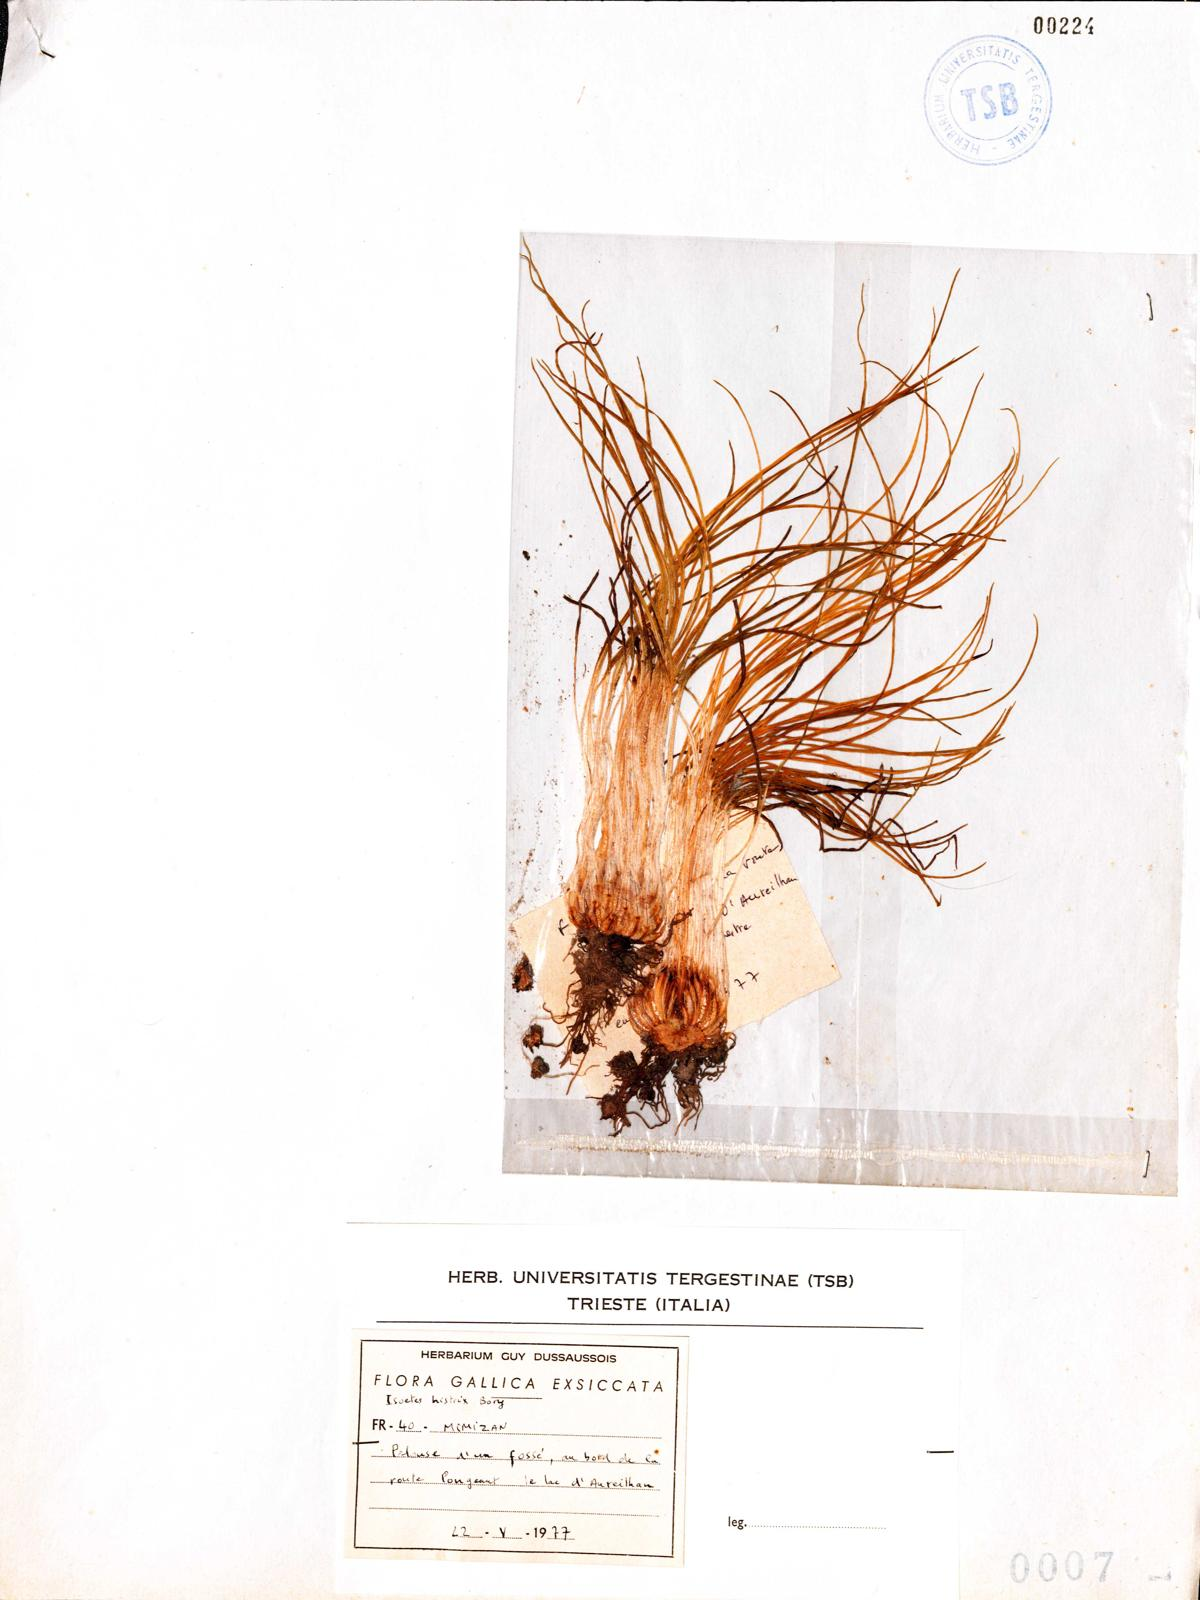

Ground Truth: {"Nome_verbatim": "Polypodium Cambricum L", "Nome_floritaly": "Polypodium cambricum L.", "Luogo_Raccolta": "Dardago", "Altitudine": " ", "Giorno": 7, "Mese": 5.0, "Anno": 2000.0}

Prediction: {'Nome_verbatim': 'Dryopteris cambricum L.P. australe', 'Nome_floritaly': 'Dryopteris cambricum L.P. australe', 'Luogo_Raccolta': 'Monte Paularo', 'Altitudine': '', 'Giorno': '', 'Mese': '', 'Anno': ''}

Score: 0.044117647058823484



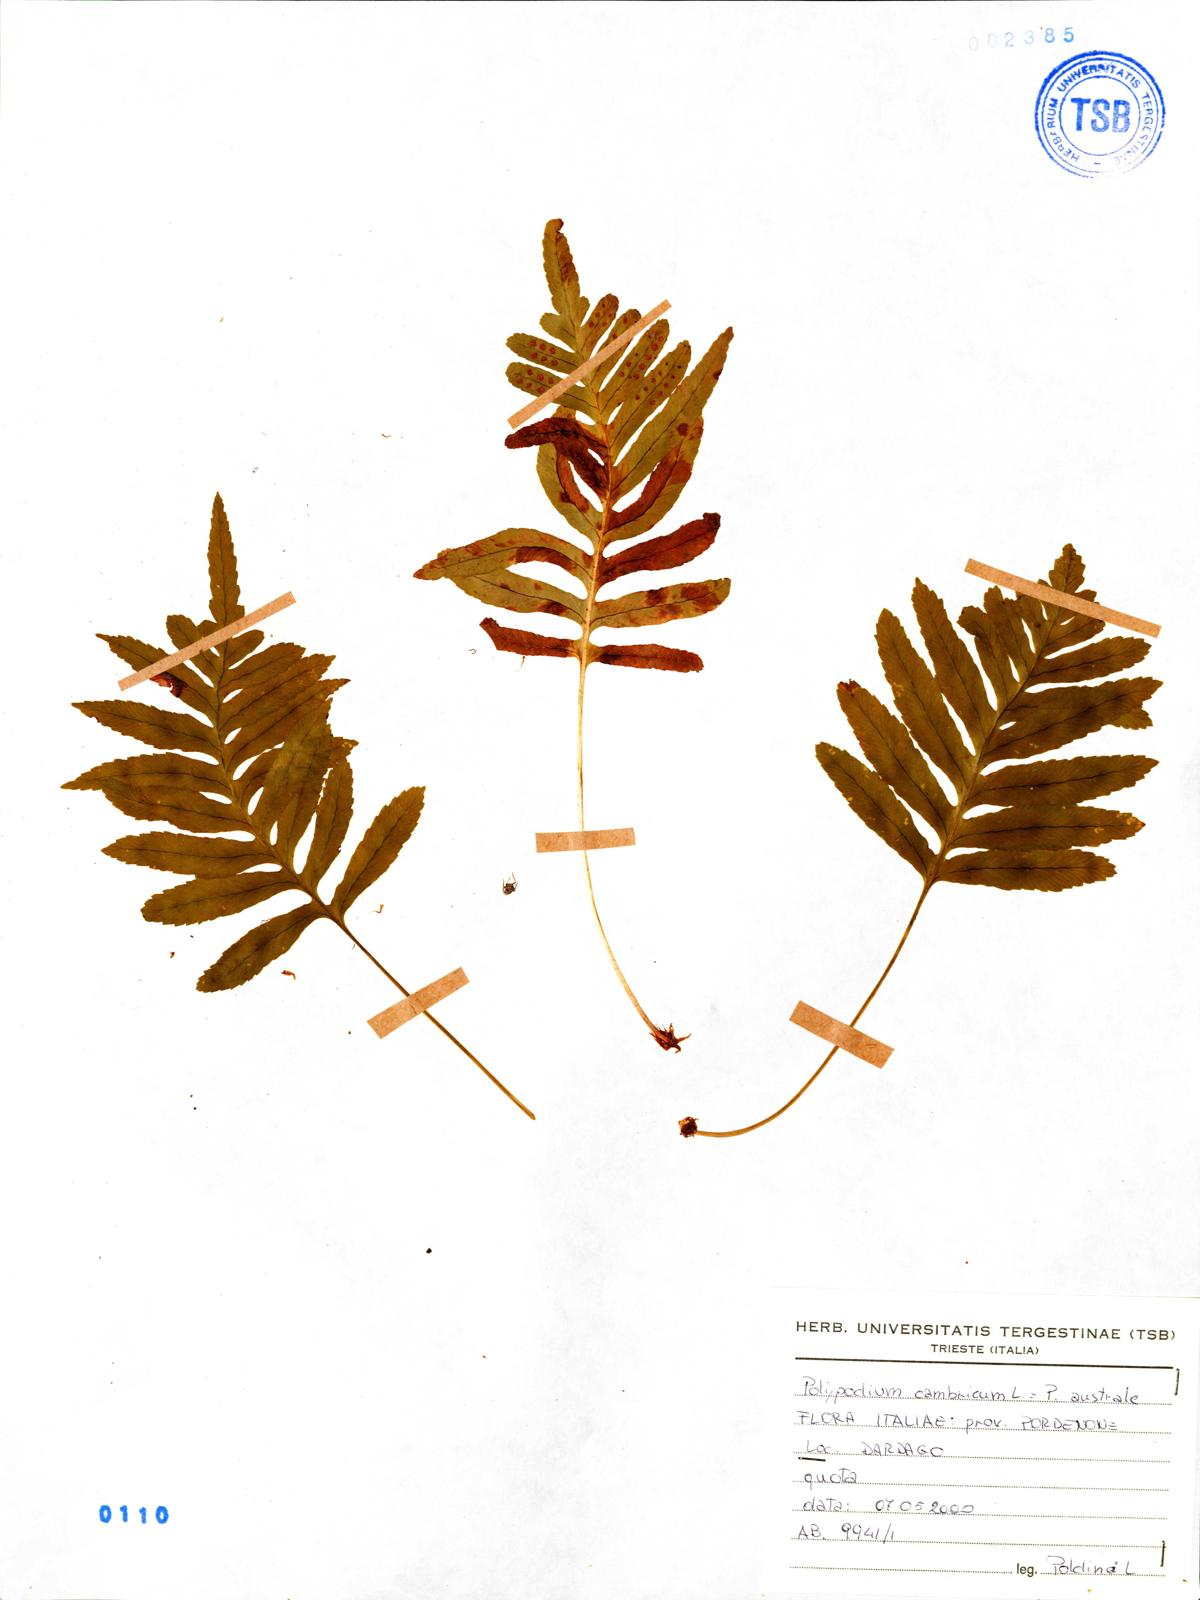

Ground Truth: {"Nome_verbatim": "Dryopteris aemula (Ait.) O. Kuntze", "Nome_floritaly": "Dryopteris aemula\n(Aiton) Kuntze", "Luogo_Raccolta": "Vall\u00e9e du Laxia", "Altitudine": " ", "Giorno": 3, "Mese": 7.0, "Anno": 1977.0}

Prediction: {'Nome_verbatim': 'Lycopodium interjectum Shivas', 'Nome_floritaly': 'Spinulum (L.) A.Haines subsp. interjectum Shivas', 'Luogo_Raccolta': 'Monte San Lorenze', 'Altitudine': '', 'Giorno': '3', 'Mese': '8.0', 'Anno': '1977.0'}

Score: 0.12371134020618557



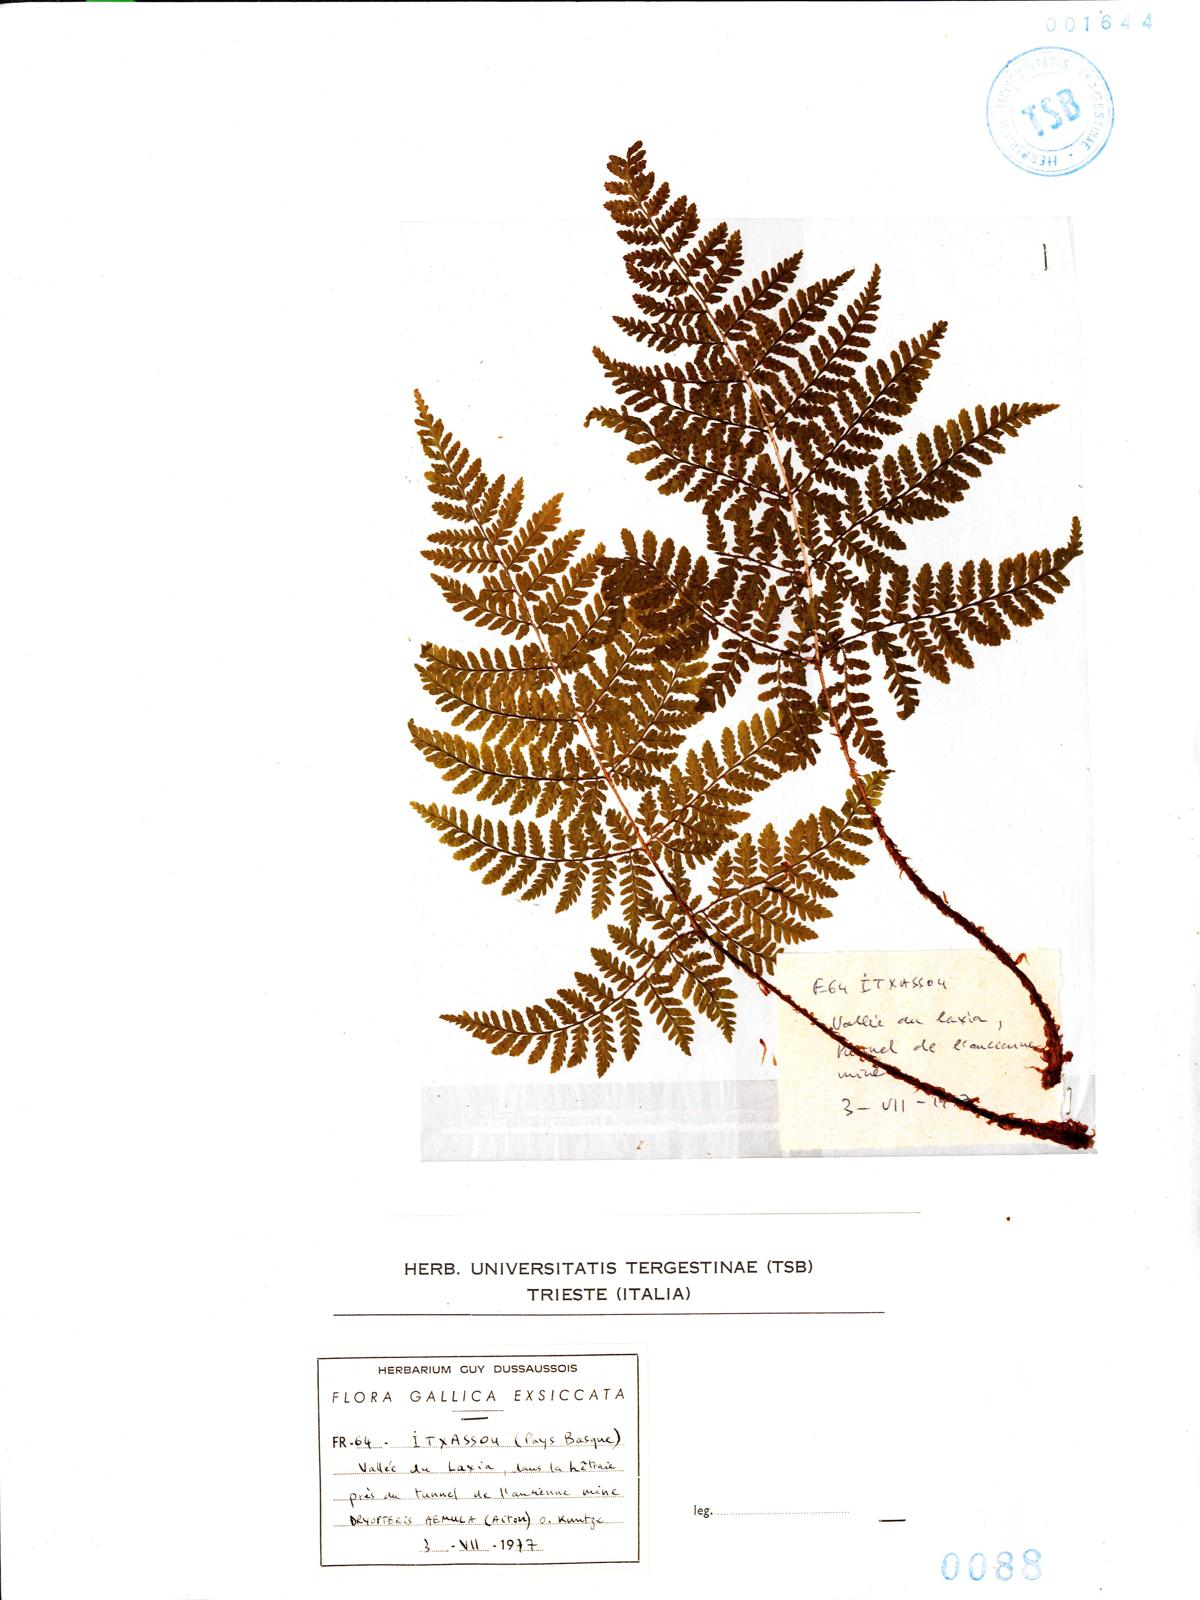

Ground Truth: {"Nome_verbatim": "Cryptogramma crispa (L.) R. Br. var acrostichoides", "Nome_floritaly": " ", "Luogo_Raccolta": "Parco nazionale di Yosemite\n", "Altitudine": " ", "Giorno": 19, "Mese": 9.0, "Anno": 1965.0}

Prediction: {'Nome_verbatim': 'Cryptogramma crispa (L.) R. Br.', 'Nome_floritaly': 'Cryptogramma crispa (L.) R.Br. ex Hook.', 'Luogo_Raccolta': 'Yosemite Valley, California', 'Altitudine': '', 'Giorno': '19', 'Mese': '9.0', 'Anno': '1965.0'}

Score: 0.12903225806451613



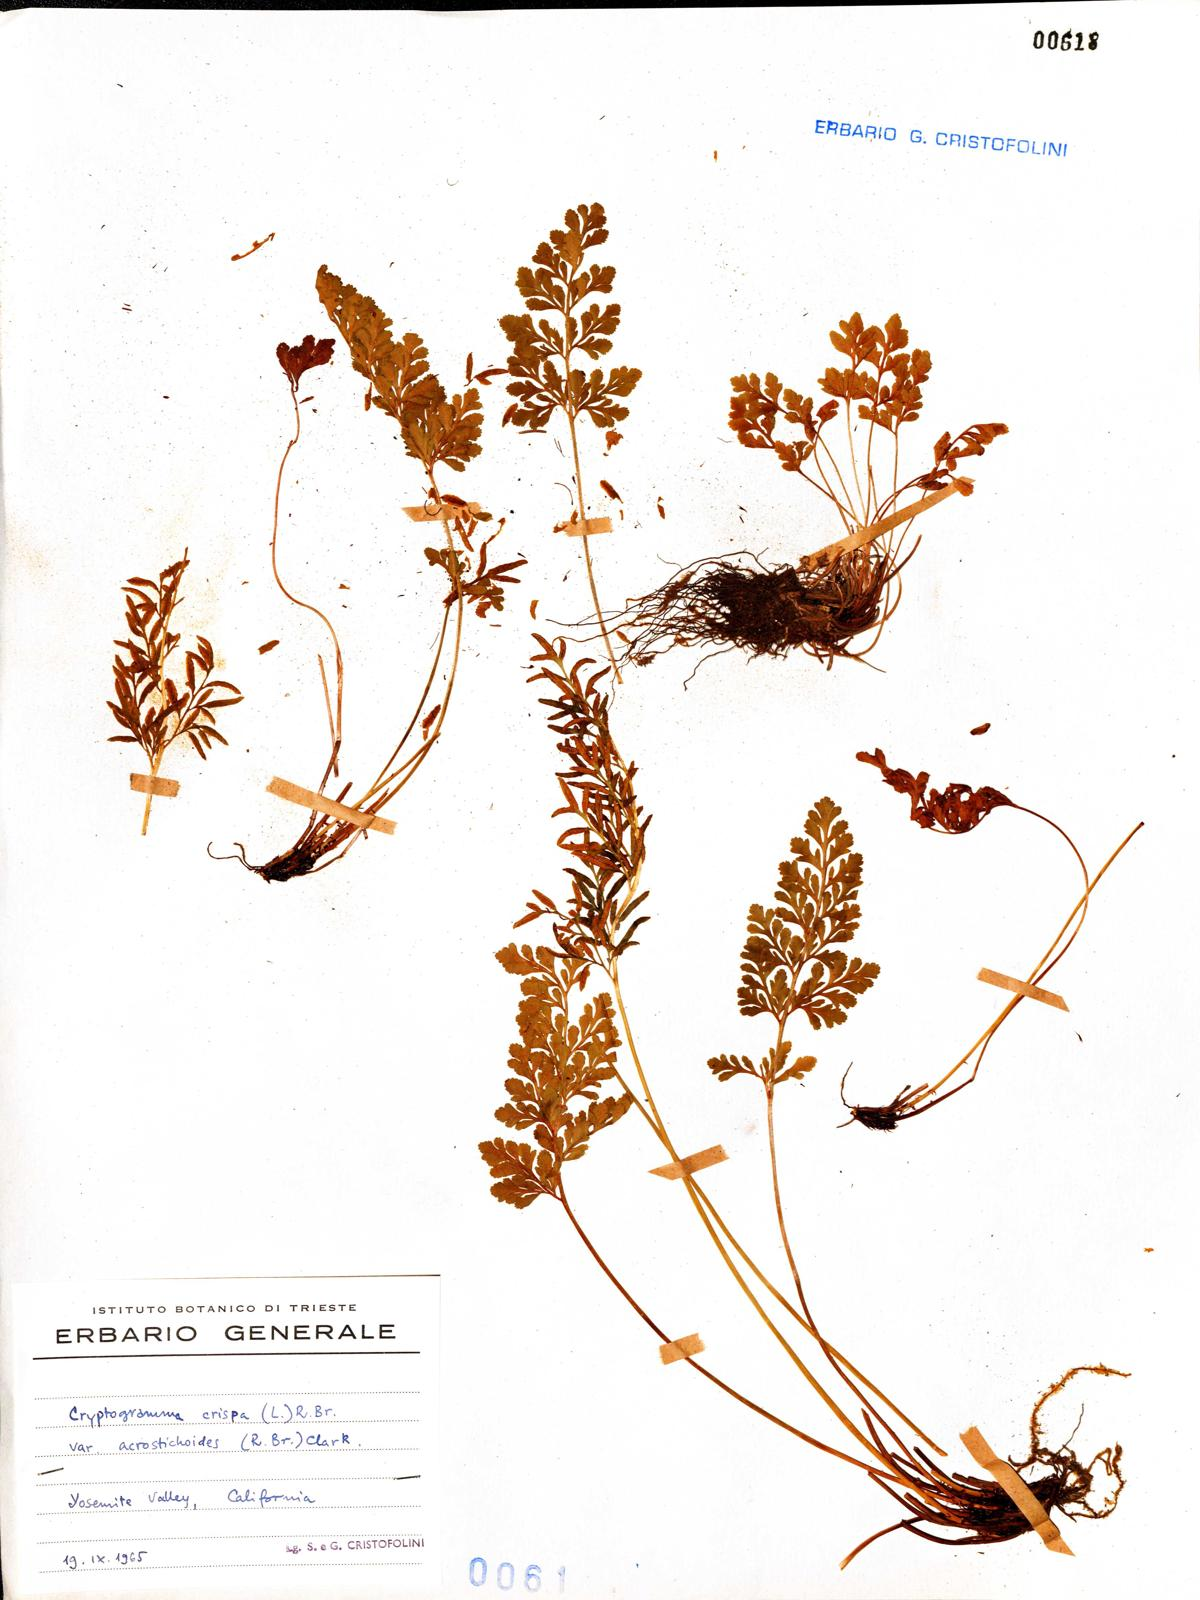

Ground Truth: {"Nome_verbatim": "Athyrium sp\n", "Nome_floritaly": " ", "Luogo_Raccolta": "Monte Paularo", "Altitudine": 1400, "Giorno": 19, "Mese": 8.0, "Anno": 1971.0}

Prediction: {'Nome_verbatim': 'Athyrium spicant', 'Nome_floritaly': 'Athyrium filix-feemina (L.) Roth', 'Luogo_Raccolta': 'Monte Paularo', 'Altitudine': '1400', 'Giorno': '19', 'Mese': '8.0', 'Anno': '1971.0'}

Score: 0.15555555555555556



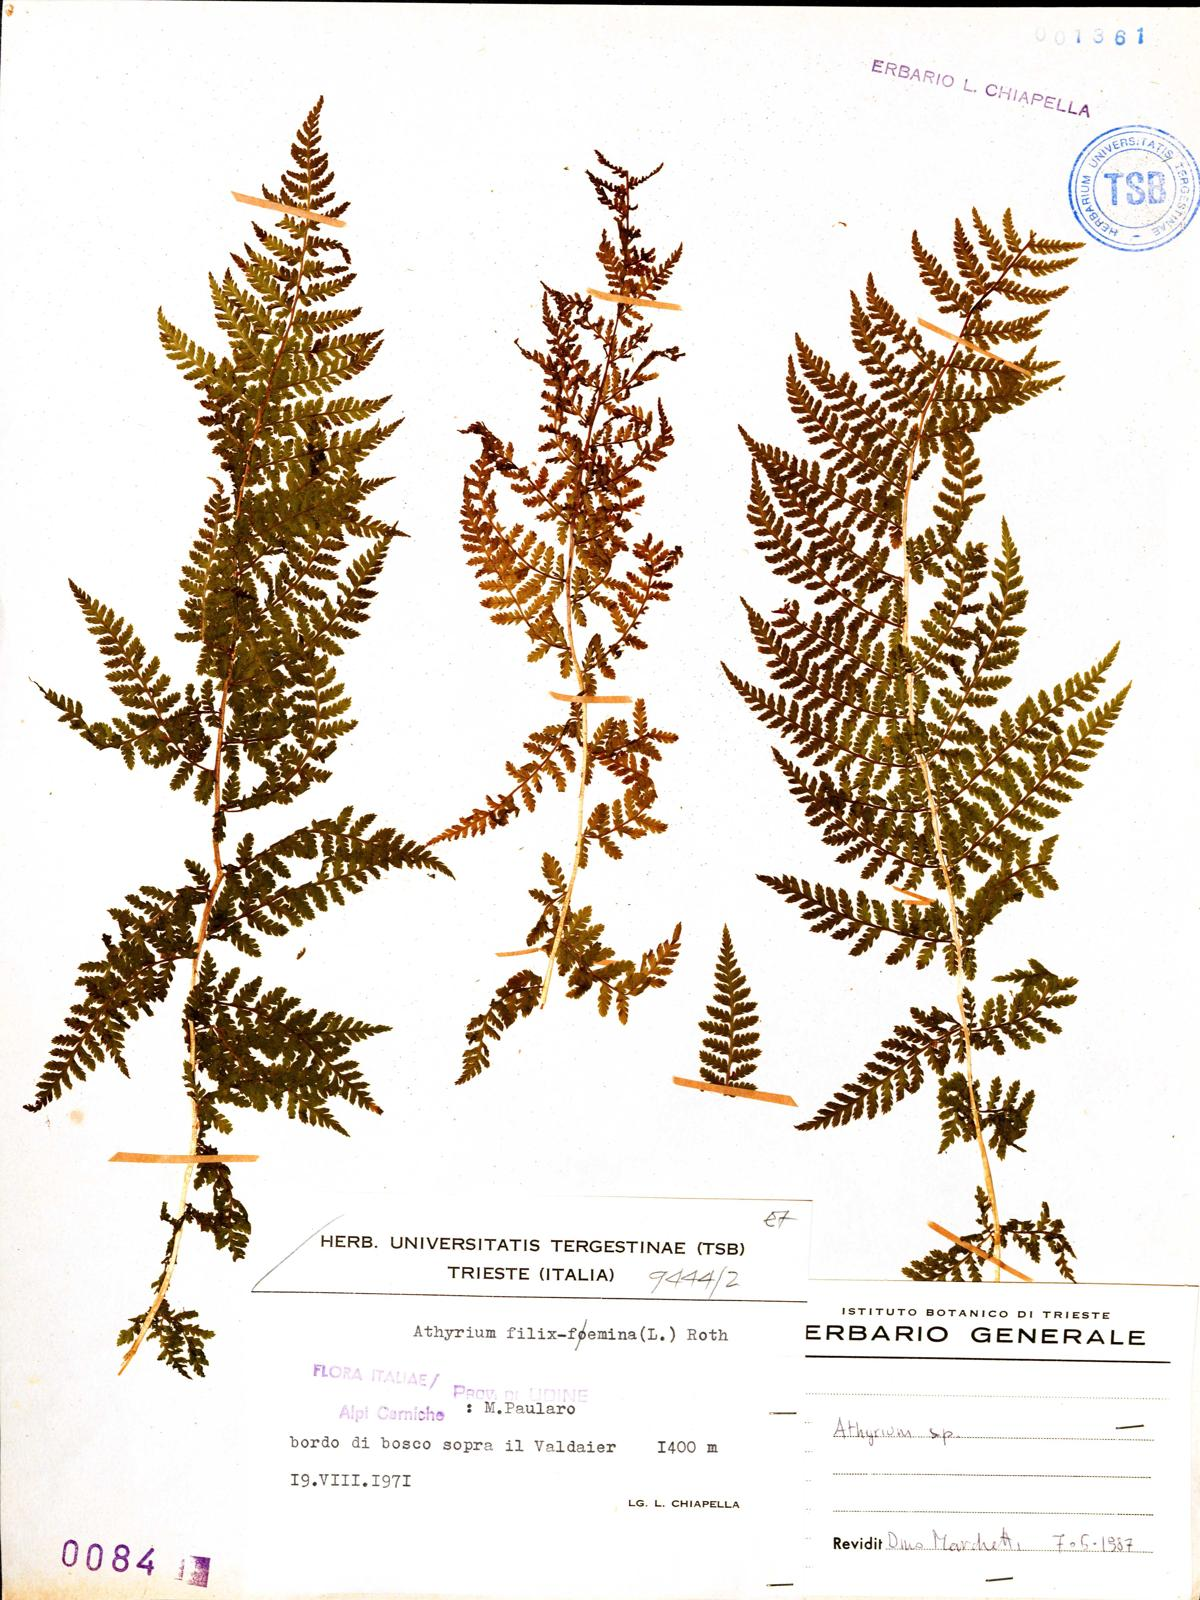

In [11]:
# get indices of worst 5 predictions
worst_idxs = np.argsort(accs)[:5].tolist()

# prepare decoder inputs
task_prompt = "<s_herbarium>"
decoder_input_ids = processor.tokenizer(task_prompt, add_special_tokens=False, return_tensors="pt").input_ids
decoder_input_ids = decoder_input_ids.to(device)

for idx in worst_idxs:
    sample = dataset[idx]

    # prepare encoder inputs
    pixel_values = processor(sample["image"].convert("RGB"), return_tensors="pt").pixel_values
    pixel_values = pixel_values.to(device)

    # autoregressively generate sequence
    outputs = model.generate(
        pixel_values,
        decoder_input_ids=decoder_input_ids,
        max_length=model.decoder.config.max_position_embeddings,
        early_stopping=True,
        pad_token_id=processor.tokenizer.pad_token_id,
        eos_token_id=processor.tokenizer.eos_token_id,
        use_cache=True,
        num_beams=1,
        bad_words_ids=[[processor.tokenizer.unk_token_id]],
        return_dict_in_generate=True,
    )

    # turn into JSON
    seq = processor.batch_decode(outputs.sequences)[0]
    seq = seq.replace(processor.tokenizer.eos_token, "").replace(processor.tokenizer.pad_token, "")
    seq = re.sub(r"<.*?>", "", seq, count=1).strip()  # remove first task start token
    seq = processor.token2json(seq)
    
    print(f"Ground Truth: {sample['ground_truth']}\n")
    print(f"Prediction: {seq}\n")
    print(f"Score: {accs[idx]}\n")
    display(sample["image"])